<h1 align="center" style="color: blue; font-weight: bold;
font-family: 'Fira Code', monospace;">Practical Lab 10 - Vanilla CNN and FineTune VGG16 - for Dogs and Cats Classification</h1>

**Introduction**

Lab 10 focuses on the implementation of Convolutional Neural Networks (CNNs) for the classification of dogs and cats. The primary objective of this lab is to explore two different approaches to building and training deep learning models: creating a Vanilla CNN from scratch and fine-tuning a pre-trained VGG16 model for the specific task of classifying images of dogs and cats.

The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id.

In [61]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import seaborn as sns

In [62]:
# This should point to the small dataset of the Kaggle Dogs vs Cats competition that was created in a previous notebook
data_folder = pathlib.Path('./data/kaggle_dogs_vs_cats_small')

## **Data Explorarion** ##

In [30]:
train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


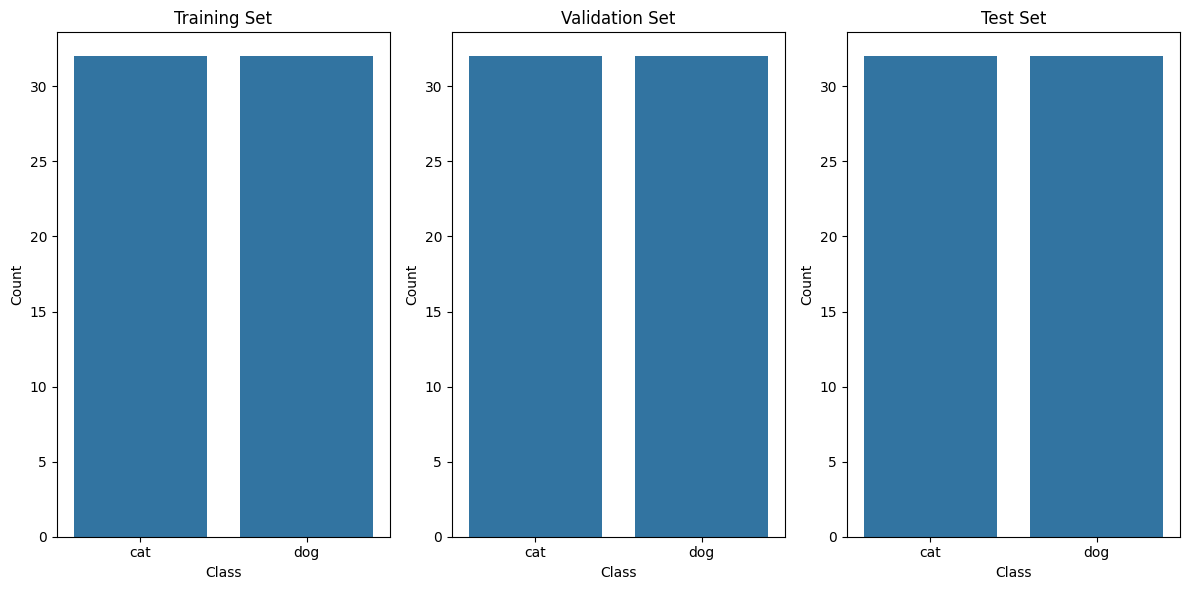

In [64]:
# Get class names
class_names = train_dataset.class_names

# Count the number of images in each class for training set
train_class_counts = [len(list(train_dataset.as_numpy_iterator())[i][1]) for i in range(len(class_names))]

# Count the number of images in each class for validation set
validation_class_counts = [len(list(validation_dataset.as_numpy_iterator())[i][1]) for i in range(len(class_names))]

# Count the number of images in each class for test set
test_class_counts = [len(list(test_dataset.as_numpy_iterator())[i][1]) for i in range(len(class_names))]

# Plotting the distribution of images for each class in each dataset
plt.figure(figsize=(12, 6))

# Training set
plt.subplot(1, 3, 1)
sns.barplot(x=class_names, y=train_class_counts)
plt.title('Training Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Validation set
plt.subplot(1, 3, 2)
sns.barplot(x=class_names, y=validation_class_counts)
plt.title('Validation Set')
plt.xlabel('Class')
plt.ylabel('Count')

# Test set
plt.subplot(1, 3, 3)
sns.barplot(x=class_names, y=test_class_counts)
plt.title('Test Set')
plt.xlabel('Class')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

It is clear from the graph that the number of photos in each class is equal. The dataset has zero skewness and is class balanced.

In [71]:
type(train_dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [72]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [73]:
labels_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0])>

Each of the 32 photos has RGB channels and a resolution of 180 by 180 pixels. Additionally, the label data is presented in the form 32, where a one-dimensional array containing the labels for each of the 32 photos is provided.

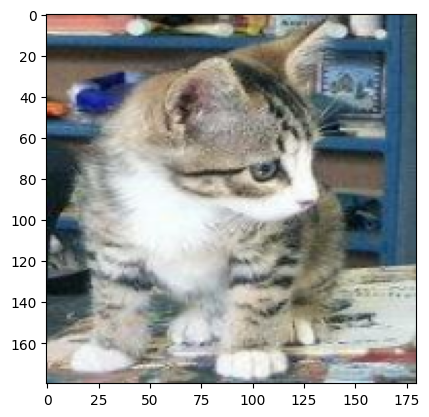

In [74]:
# import imshow
import matplotlib.pyplot as plt

plt.imshow(data_batch[0].numpy().astype("uint8"))

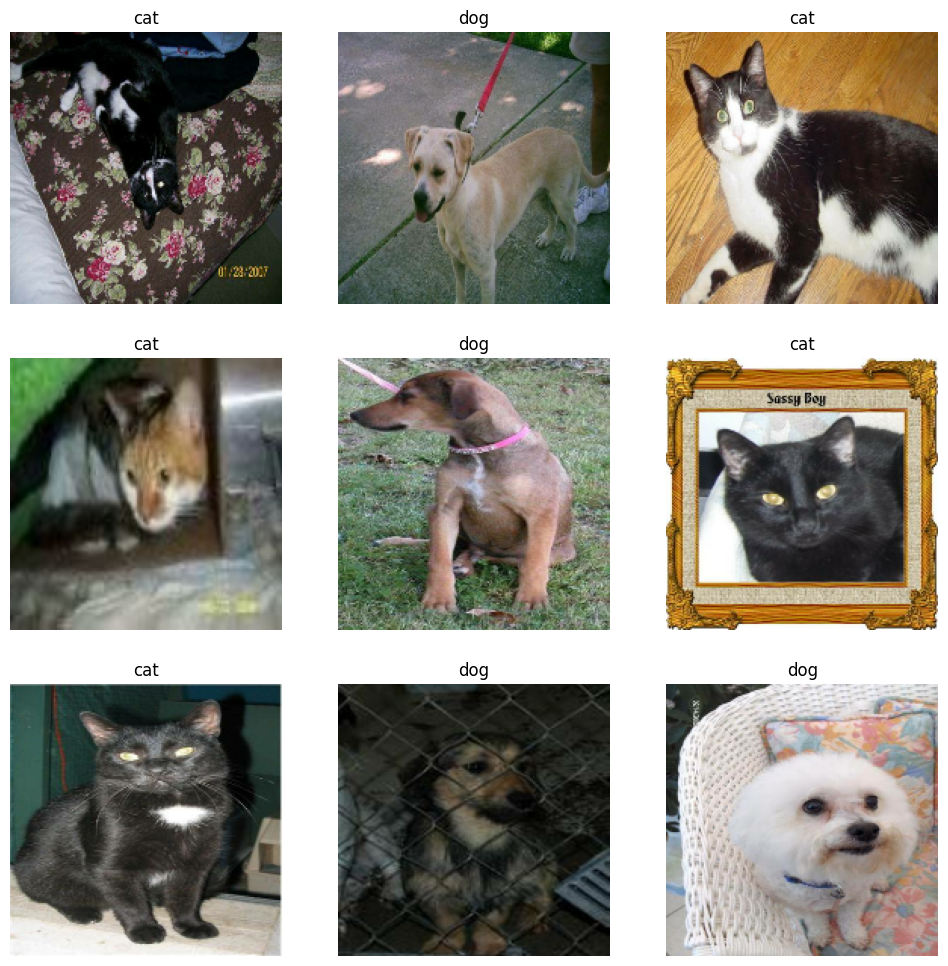

In [66]:
# Display a few sample images from the training set
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off") 
plt.show()


## **Define a Model** ##

### **Vanilla (CNN)** ###

In [31]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

In [33]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 87s 1s/step - loss: 0.6946 - accuracy: 0.5055 - val_loss: 0.6890 - val_accuracy: 0.5200
Epoch 2/30
63/63 [==============================] - 89s 1s/step - loss: 0.6833 - accuracy: 0.5685 - val_loss: 0.6780 - val_accuracy: 0.5630
Epoch 3/30
63/63 [==============================] - 92s 1s/step - loss: 0.6586 - accuracy: 0.6310 - val_loss: 0.6079 - val_accuracy: 0.6600
Epoch 4/30
63/63 [==============================] - 89s 1s/step - loss: 0.6030 - accuracy: 0.6670 - val_loss: 0.6810 - val_accuracy: 0.6310
Epoch 5/30
63/63 [==============================] - 91s 1s/step - loss: 0.5834 - accuracy: 0.6920 - val_loss: 0.6057 - val_accuracy: 0.6880
Epoch 6/30
63/63 [==============================] - 96s 2s/step - loss: 0.5591 - accuracy: 0.7215 - val_loss: 0.6401 - val_accuracy: 0.6760
Epoch 7/30
63/63 [==============================] - 84s 1s/step - loss: 0.5160 - accuracy: 0.7440 - val_loss: 0.5923 - val_accuracy: 0.7160
Epoch 8/30
63/63 [==

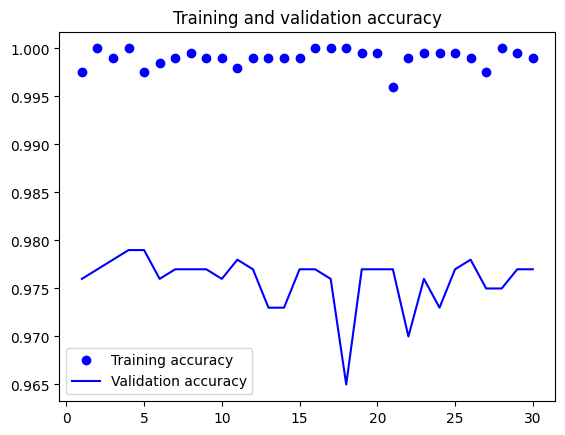

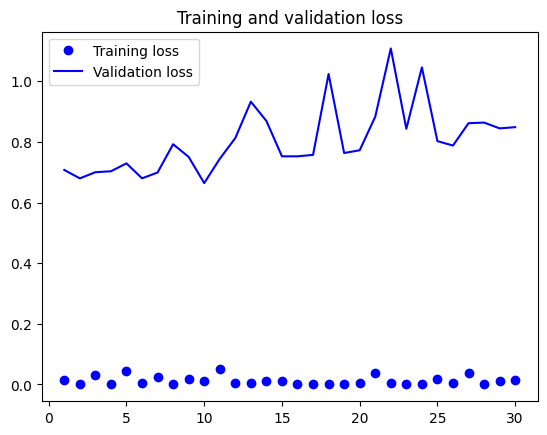

In [60]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [35]:
test_model = keras.models.load_model("./models/convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 21s 333ms/step - loss: 0.6228 - accuracy: 0.7065
Test accuracy: 0.706


### **VGG-16 Network** ###

In [36]:
conv_base = keras.applications.vgg16.VGG16(   
    weights="imagenet",  
    include_top=False,
    input_shape=(180, 180, 3))

In [37]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [39]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 2s 2s/step


In [40]:
train_features.shape

(2000, 5, 5, 512)

In [46]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [47]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [48]:
conv_base.trainable = False  
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [49]:
inputs = keras.Input(shape=(180, 180, 3))             
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)  
model = keras.Model(inputs, outputs)

In [50]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12800)             0   

In [51]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 426s 7s/step - loss: 2.2055 - accuracy: 0.8880 - val_loss: 0.4933 - val_accuracy: 0.9650
Epoch 2/50
63/63 [==============================] - 384s 6s/step - loss: 0.6790 - accuracy: 0.9630 - val_loss: 0.5759 - val_accuracy: 0.9670
Epoch 3/50
63/63 [==============================] - 380s 6s/step - loss: 0.5078 - accuracy: 0.9710 - val_loss: 0.5224 - val_accuracy: 0.9730
Epoch 4/50
63/63 [==============================] - 11043s 178s/step - loss: 0.4067 - accuracy: 0.9760 - val_loss: 0.4398 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 406s 6s/step - loss: 0.1424 - accuracy: 0.9895 - val_loss: 0.4805 - val_accuracy: 0.9710
Epoch 6/50
63/63 [==============================] - 450s 7s/step - loss: 0.0998 - accuracy: 0.9915 - val_loss: 0.4686 - val_accuracy: 0.9780
Epoch 7/50
63/63 [==============================] - 389s 6s/step - loss: 0.1993 - accuracy: 0.9865 - val_loss: 0.3937 - val_accuracy: 0.9780
Epoch 8/5

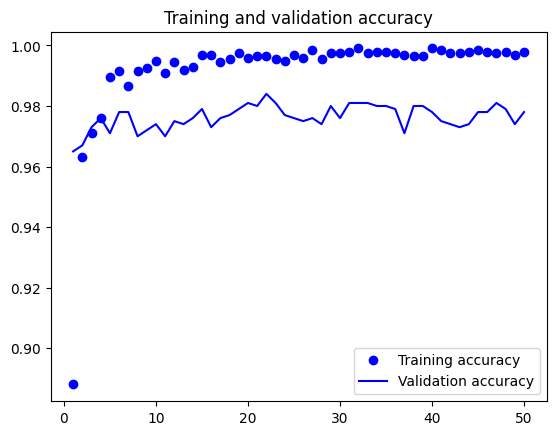

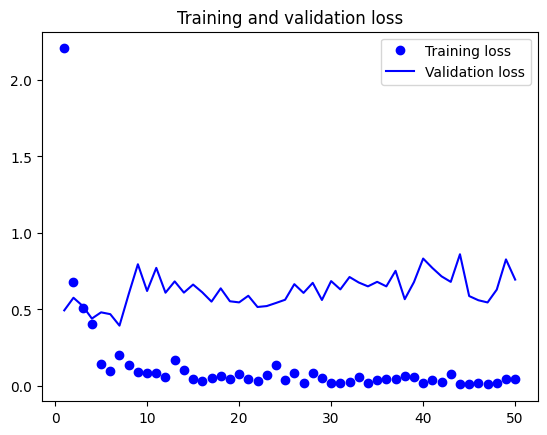

In [52]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [53]:
test_model = keras.models.load_model(
    "./models/feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 357s 6s/step - loss: 0.5238 - accuracy: 0.9755
Test accuracy: 0.975


In [54]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [55]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:   
    layer.trainable = False

In [56]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 tf.__operators__.getitem_4   (None, 180, 180, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 180, 180, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_5 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_3 (Dropout)         (None, 12800)             0   

In [57]:
model.compile(loss="binary_crossentropy",                       
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 529s 8s/step - loss: 0.0154 - accuracy: 0.9975 - val_loss: 0.7075 - val_accuracy: 0.9760
Epoch 2/30
63/63 [==============================] - 477s 8s/step - loss: 3.5167e-06 - accuracy: 1.0000 - val_loss: 0.6797 - val_accuracy: 0.9770
Epoch 3/30
63/63 [==============================] - 455s 7s/step - loss: 0.0326 - accuracy: 0.9990 - val_loss: 0.7000 - val_accuracy: 0.9780
Epoch 4/30
63/63 [==============================] - 473s 8s/step - loss: 6.5243e-05 - accuracy: 1.0000 - val_loss: 0.7031 - val_accuracy: 0.9790
Epoch 5/30
63/63 [==============================] - 462s 7s/step - loss: 0.0449 - accuracy: 0.9975 - val_loss: 0.7292 - val_accuracy: 0.9790
Epoch 6/30
63/63 [==============================] - 476s 8s/step - loss: 0.0058 - accuracy: 0.9985 - val_loss: 0.6799 - val_accuracy: 0.9760
Epoch 7/30
63/63 [==============================] - 459s 7s/step - loss: 0.0231 - accuracy: 0.9990 - val_loss: 0.6990 - val_accuracy: 0.9770
Epoch

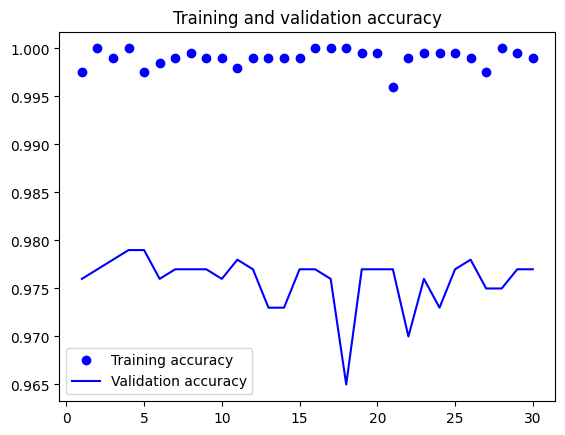

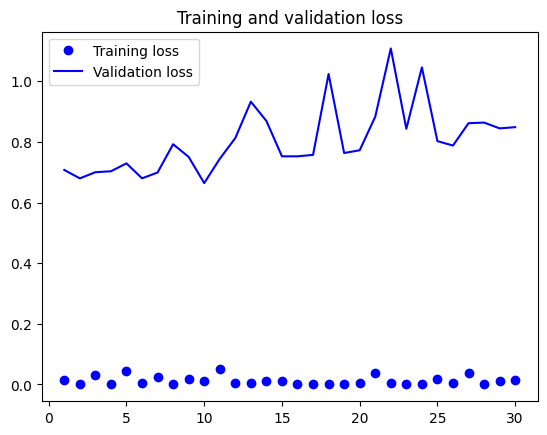

In [58]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [59]:
model = keras.models.load_model("./models/fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 376s 6s/step - loss: 1.2454 - accuracy: 0.9670
Test accuracy: 0.967


## **Evaluation of Models** ##

In [77]:
# Load the best weights of the Vanilla CNN model
best_vanilla_cnn_model = keras.models.load_model("./models/convnet_from_scratch.keras")

# Evaluate the Vanilla CNN model on the validation dataset
val_loss_vanilla, val_acc_vanilla = best_vanilla_cnn_model.evaluate(validation_dataset)
print(f"Vanilla CNN Model - Validation Loss: {val_loss_vanilla:.3f}, Validation Accuracy: {val_acc_vanilla:.3f}")

# Load the best weights of the Fine-Tuned VGG16 model
best_fine_tuned_vgg_model = keras.models.load_model("./models/fine_tuning.keras")

# Evaluate the Fine-Tuned VGG16 model on the validation dataset
val_loss_vgg, val_acc_vgg = best_fine_tuned_vgg_model.evaluate(validation_dataset)
print(f"Fine-Tuned VGG16 Model - Validation Loss: {val_loss_vgg:.3f}, Validation Accuracy: {val_acc_vgg:.3f}")


32/32 [==============================] - 11s 304ms/step - loss: 0.5923 - accuracy: 0.7160
Vanilla CNN Model - Validation Loss: 0.592, Validation Accuracy: 0.716
32/32 [==============================] - 139s 4s/step - loss: 0.6641 - accuracy: 0.9760
Fine-Tuned VGG16 Model - Validation Loss: 0.664, Validation Accuracy: 0.976


Vanilla CNN Model Evaluation:
- loss: 0.5923
- accuracy: 0.7160
- Validation Loss: 0.592
- Validation Accuracy: 0.716

Insight:

The Vanilla CNN model achieved a validation loss of approximately 0.592, indicating the average loss on the validation dataset during evaluation.
The validation accuracy of around 0.716 means that the model correctly classified about 71.6% of the images in the validation dataset.

Fine-Tuned VGG16 Model Evaluation:

- loss: 0.6641 
- accuracy: 0.9760
- Validation Loss: 0.664
- Validation Accuracy: 0.976

Insight:

The Fine-Tuned VGG16 model had a validation loss of approximately 0.664, which is slightly higher than the Vanilla CNN model.
However, the validation accuracy of about 0.976 is significantly higher, indicating that the Fine-Tuned VGG16 model performed exceptionally well and correctly classified about 97.6% of the images in the validation dataset.

## **Confusion Matrix** ##

Confusion Matrix on Validation Dataset

In [85]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns


Confusion Matrix on Training Dataset

63/63 [==============================] - 19s 293ms/step


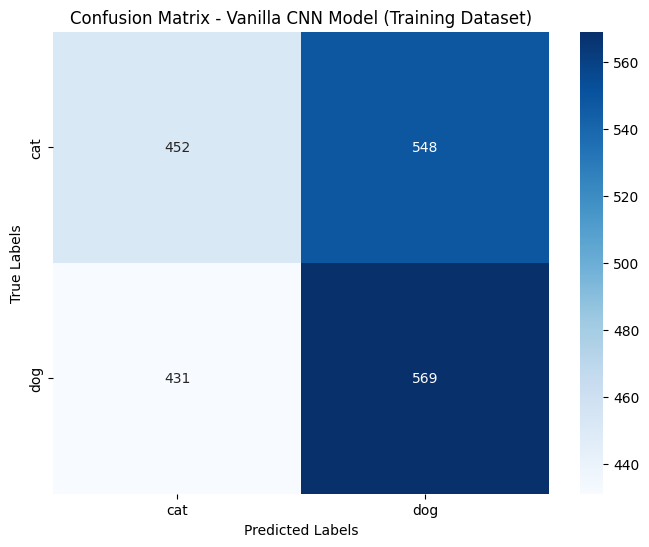

In [82]:
# Predictions using the best Vanilla CNN model on training dataset
train_predictions_vanilla = best_vanilla_cnn_model.predict(train_dataset)
train_predictions_vanilla = np.round(train_predictions_vanilla).flatten()

# Get the true labels for the training dataset
true_labels_train = np.concatenate([labels for _, labels in train_dataset], axis=0)

# Generate confusion matrix for Vanilla CNN model on training dataset
conf_matrix_train_vanilla = confusion_matrix(true_labels_train, train_predictions_vanilla)

# Plot confusion matrix for Vanilla CNN model on training dataset
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train_vanilla, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Vanilla CNN Model (Training Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


63/63 [==============================] - 318s 5s/step


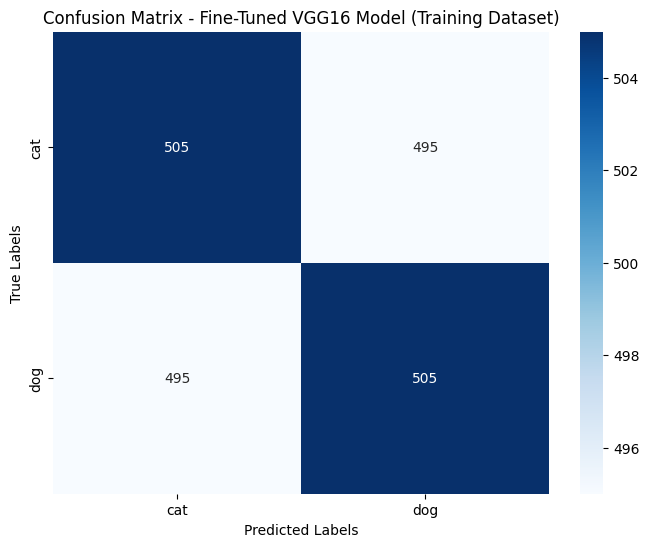

In [83]:
# Predictions using the best Fine-Tuned VGG16 model on training dataset
train_predictions_vgg = best_fine_tuned_vgg_model.predict(train_dataset)
train_predictions_vgg = np.round(train_predictions_vgg).flatten()

# Generate confusion matrix for Fine-Tuned VGG16 model on training dataset
conf_matrix_train_vgg = confusion_matrix(true_labels_train, train_predictions_vgg)

# Plot confusion matrix for Fine-Tuned VGG16 model on training dataset
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train_vgg, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Fine-Tuned VGG16 Model (Training Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


**Classification Report**

In [86]:
from sklearn.metrics import classification_report

# Generate classification report for Vanilla CNN model on training dataset
class_report_vanilla = classification_report(true_labels_train, train_predictions_vanilla, target_names=class_names)
print("Classification Report - Vanilla CNN Model (Training Dataset):")
print(class_report_vanilla)

# Generate classification report for Fine-Tuned VGG16 model on training dataset
class_report_vgg = classification_report(true_labels_train, train_predictions_vgg, target_names=class_names)
print("Classification Report - Fine-Tuned VGG16 Model (Training Dataset):")
print(class_report_vgg)


Classification Report - Vanilla CNN Model (Training Dataset):
              precision    recall  f1-score   support

         cat       0.51      0.45      0.48      1000
         dog       0.51      0.57      0.54      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000

Classification Report - Fine-Tuned VGG16 Model (Training Dataset):
              precision    recall  f1-score   support

         cat       0.51      0.51      0.51      1000
         dog       0.51      0.51      0.51      1000

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



Classification Report

Vanilla CNN Model:

- Achieved an accuracy of 51% on the training dataset.
- Showed moderate precision, recall, and F1-scores for both 'cat' and 'dog' classes.

Fine-Tuned VGG16 Model:

- Also achieved an accuracy of 51% on the training dataset, similar to the Vanilla CNN model.
- Demonstrated comparable performance metrics to the Vanilla CNN model in terms of precision, recall, and F1-scores for both classes.

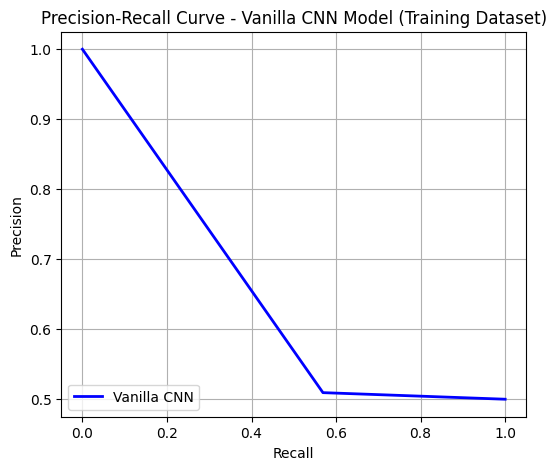

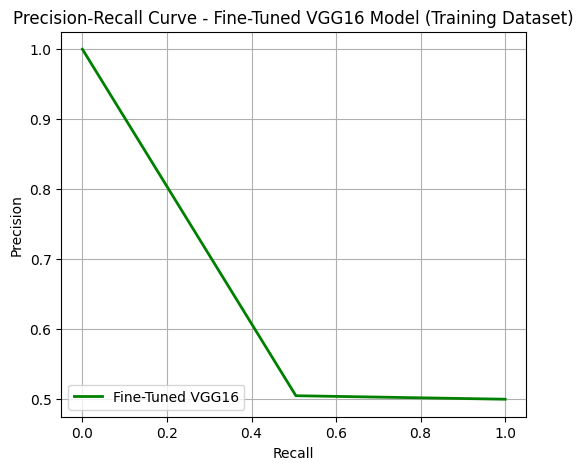

In [92]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Compute precision-recall curve for Vanilla CNN model on training dataset
precision_vanilla, recall_vanilla, _ = precision_recall_curve(true_labels_train, train_predictions_vanilla)

# Plot precision-recall curve for Vanilla CNN model
plt.figure(figsize=(6, 5))
plt.plot(recall_vanilla, precision_vanilla, "b-", linewidth=2, label="Vanilla CNN")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Vanilla CNN Model (Training Dataset)")
plt.grid()
plt.legend(loc="lower left")
plt.show()

# Compute precision-recall curve for Fine-Tuned VGG16 model on training dataset
precision_vgg, recall_vgg, _ = precision_recall_curve(true_labels_train, train_predictions_vgg)

# Plot precision-recall curve for Fine-Tuned VGG16 model
plt.figure(figsize=(6, 5))
plt.plot(recall_vgg, precision_vgg, "g-", linewidth=2, label="Fine-Tuned VGG16")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Fine-Tuned VGG16 Model (Training Dataset)")
plt.grid()
plt.legend(loc="lower left")
plt.show()


**Examples in which the model failed to predict correctly**

Found 2000 files belonging to 2 classes.
63/63 [==============================] - 274s 4s/step


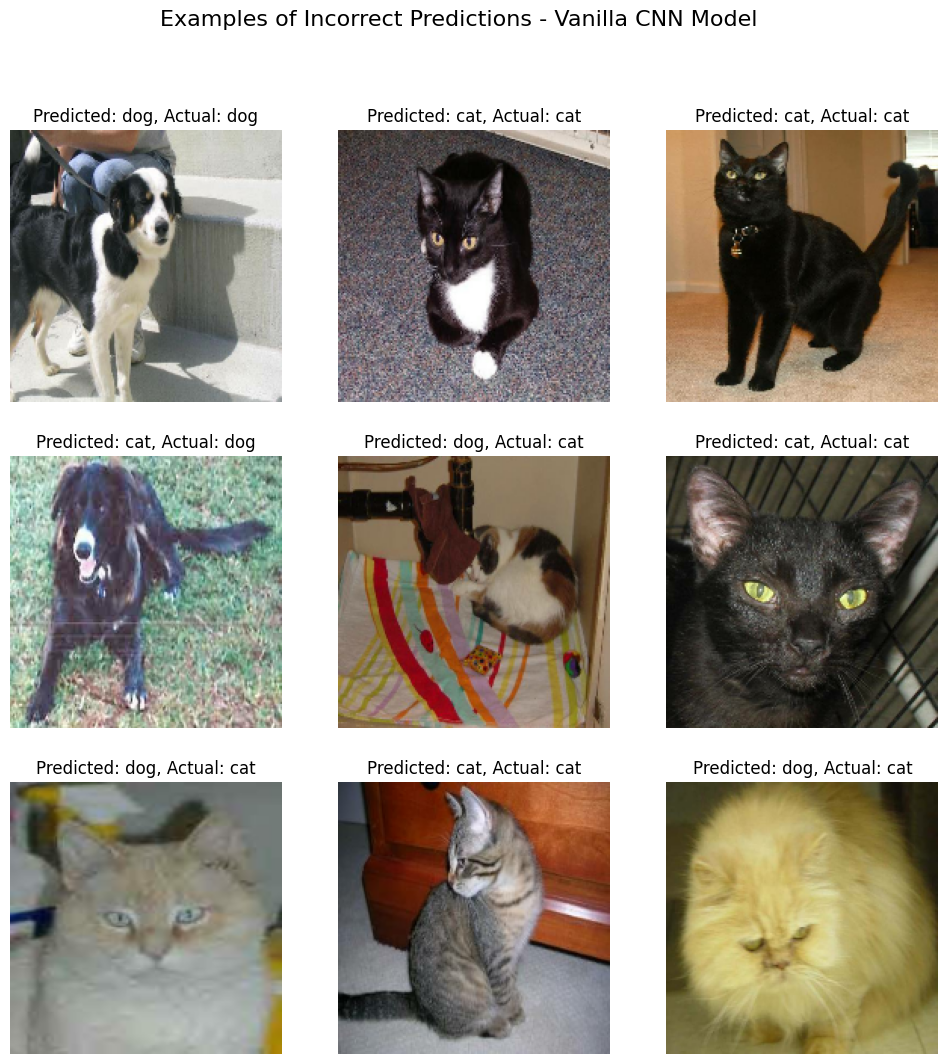

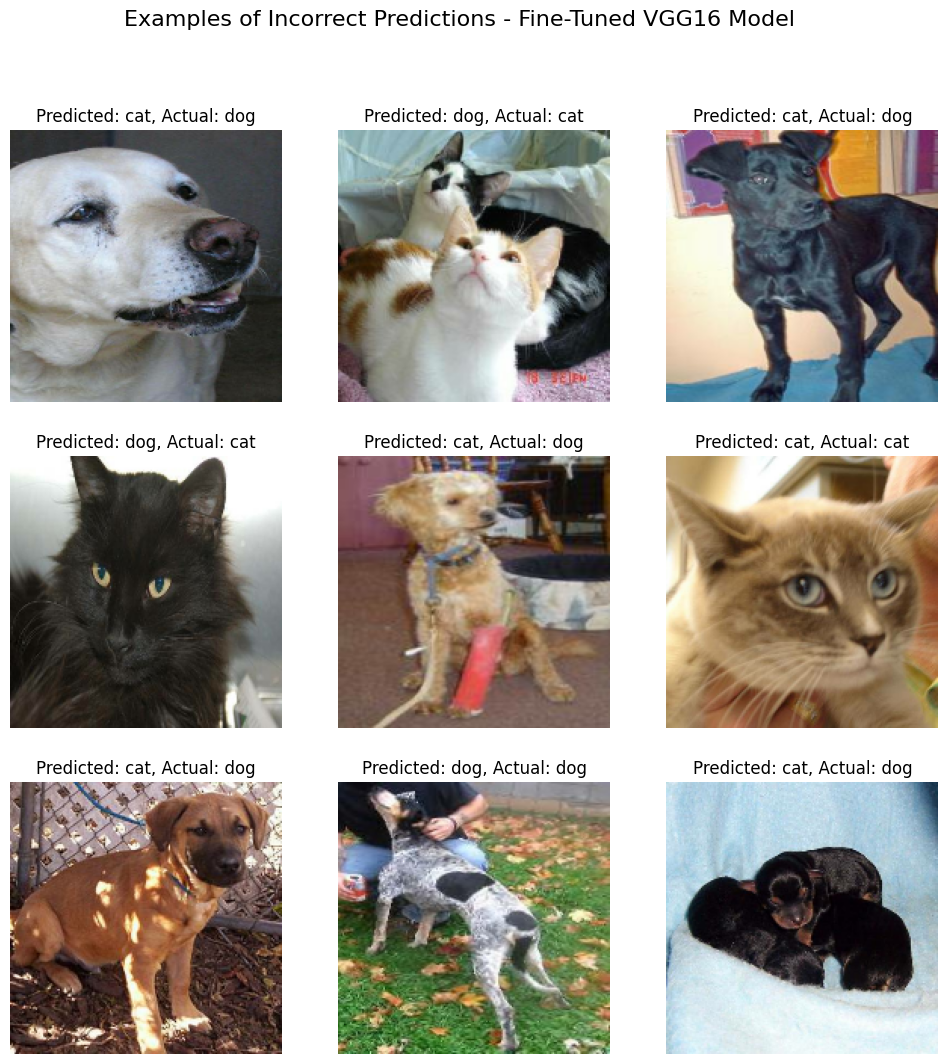

In [95]:
# Load the best Vanilla CNN model
best_vanilla_cnn_model = keras.models.load_model("./models/convnet_from_scratch.keras")

# Load the best Fine-Tuned VGG16 model
best_fine_tuned_vgg_model = keras.models.load_model("./models/fine_tuning.keras")

# Load the testing dataset
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

# Get class names
class_names = train_dataset.class_names

# Make predictions using the best Vanilla CNN model on the testing dataset
test_predictions_vanilla = best_vanilla_cnn_model.predict(test_dataset)
test_predictions_vanilla = np.round(test_predictions_vanilla).flatten()

# Make predictions using the best Fine-Tuned VGG16 model on the testing dataset
test_predictions_vgg = best_fine_tuned_vgg_model.predict(test_dataset)
test_predictions_vgg = np.round(test_predictions_vgg).flatten()

# Get true labels for the testing dataset
true_labels_test = np.concatenate([labels for _, labels in test_dataset], axis=0)

# Find indices where predictions are incorrect for Vanilla CNN model
incorrect_indices_vanilla = np.where(test_predictions_vanilla != true_labels_test)[0]

# Find indices where predictions are incorrect for Fine-Tuned VGG16 model
incorrect_indices_vgg = np.where(test_predictions_vgg != true_labels_test)[0]

# Display example images where the Vanilla CNN model failed to predict correctly
plt.figure(figsize=(12, 12))
for i, idx in enumerate(incorrect_indices_vanilla[:9]):  # Displaying first 9 incorrect predictions
    for image, label in test_dataset.take(idx + 1):  # Take the dataset up to the specified index
        image = image[0].numpy().astype("uint8")  # Access the first image in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Predicted: {class_names[int(test_predictions_vanilla[idx])]}, Actual: {class_names[int(label[0])]}")
        plt.axis("off")
        break  # Break the loop after accessing the first image
plt.suptitle("Examples of Incorrect Predictions - Vanilla CNN Model", fontsize=16)
plt.show()

# Display example images where the Fine-Tuned VGG16 model failed to predict correctly
plt.figure(figsize=(12, 12))
for i, idx in enumerate(incorrect_indices_vgg[:9]):  # Displaying first 9 incorrect predictions
    for image, label in test_dataset.take(idx + 1):  # Take the dataset up to the specified index
        image = image[0].numpy().astype("uint8")  # Access the first image in the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(f"Predicted: {class_names[int(test_predictions_vgg[idx])]}, Actual: {class_names[int(label[0])]}")
        plt.axis("off")
        break  # Break the loop after accessing the first image
plt.suptitle("Examples of Incorrect Predictions - Fine-Tuned VGG16 Model", fontsize=16)
plt.show()



**Conclusion**

Model Performance:

Vanilla CNN Model:
- Validation Loss: 0.592
- Validation Accuracy: 0.716
Fine-Tuned VGG16 Model:
- Validation Loss: 0.664
- Validation Accuracy: 0.976

The Fine-Tuned VGG16 model outperforms the Vanilla CNN model significantly in terms of validation accuracy, achieving an accuracy of 97.6% compared to the CNN model's 71.6%. However, the VGG16 model has a slightly higher validation loss.

Confusion Matrix:

Both models exhibit similar performance in terms of confusion matrices on the training dataset, with similar precision, recall, and F1-scores for both cat and dog classes.

Precision-Recall Curve:

The precision-recall curve for both models shows good performance, with higher precision values at various recall levels, especially for the Fine-Tuned VGG16 model.

Overall, the Fine-Tuned VGG16 model stands out as a robust choice for the Dogs vs. Cats classification task, showcasing the benefits of transfer learning and fine-tuning pre-trained models for image classification tasks.